In [2]:
# Conectarea la Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importuri generale
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pentru împărțirea datelor
from sklearn.model_selection import train_test_split

# Pentru metrici și matrice de confuzie
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Pentru Random Forest (model ML clasic)
from sklearn.ensemble import RandomForestClassifier

# Pentru TensorFlow și Keras - modele CNN și augmentare
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping

# Pentru conversie vectori caracteristici
from sklearn.preprocessing import LabelEncoder

In [4]:
# Configurări
img_height = 180
img_width = 180
batch_size = 32 # Dimensiunea lotului pentru procesarea datelor
AUTOTUNE = tf.data.AUTOTUNE # Optimizează automat numărul de apeluri paralele

In [5]:
# Definirea căilor către date
# Calea către folderul principal
base_path = '/content/drive/MyDrive/butterfly_dataset/'

# CSV-ul cu denumiri și etichete
csv_path = os.path.join(base_path, 'Training_set.csv')

# Folderul cu imaginile
images_path = os.path.join(base_path, 'train')

In [6]:
# Încărcarea CSV-ului și pregătirea căii complete către imagini
# Citim CSV-ul
df = pd.read_csv(csv_path)

# Adăugăm coloana cu calea completă către imagine
df['filepath'] = df['filename'].apply(lambda x: os.path.join(images_path, x))

# Verificăm primele rânduri
df.head()

,filename,label,filepath
0,Image_1.jpg,SOUTHERN DOGFACE,/content/drive/MyDrive/butterfly_dataset/train...
1,Image_2.jpg,ADONIS,/content/drive/MyDrive/butterfly_dataset/train...
2,Image_3.jpg,BROWN SIPROETA,/content/drive/MyDrive/butterfly_dataset/train...
3,Image_4.jpg,MONARCH,/content/drive/MyDrive/butterfly_dataset/train...
4,Image_5.jpg,GREEN CELLED CATTLEHEART,/content/drive/MyDrive/butterfly_dataset/train...


In [7]:
# Împărțirea în train / val / test (80/10/10)
from sklearn.model_selection import train_test_split

# Împărțire inițială: 80% train, 20% rest
df_train, df_rest = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Din cei 20%, împărțim egal între validare și test
df_val, df_test = train_test_split(df_rest, test_size=0.5, stratify=df_rest['label'], random_state=42)

# Verificăm proporțiile
print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))

Train: 5199
Validation: 650
Test: 650


In [8]:
# Augmentare pentru imaginile de antrenament
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Doar normalizare pentru validare și testare
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# Definim generatoare cu augmentare pentru antrenare
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pentru validare și test doar rescale, fără augmentare
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generatorul pentru antrenament
train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Generatorul pentru validare
val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generatorul pentru test
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5199 validated image filenames belonging to 75 classes.
Found 650 validated image filenames belonging to 75 classes.
Found 650 validated image filenames belonging to 75 classes.


In [10]:
# Verificare clase
classes = list(train_generator.class_indices.keys())

# Împărțim lista în două coloane aproximativ egale
half = (len(classes) + 1) // 2
col1 = classes[:half]
col2 = classes[half:]

# Completăm col2 dacă are mai puține elemente
if len(col2) < len(col1):
    col2.append('')

# Afișăm cu aliniere fixă, să arate ca un tabel
print(f"{'Clasa 1':<25} {'Clasa 2':<25}")
print("-" * 50)
for c1, c2 in zip(col1, col2):
    print(f"{c1:<25} {c2:<25}")

Clasa 1                   Clasa 2                  
--------------------------------------------------
ADONIS                    LARGE MARBLE             
AFRICAN GIANT SWALLOWTAIL MALACHITE                
AMERICAN SNOOT            MANGROVE SKIPPER         
AN 88                     MESTRA                   
APPOLLO                   METALMARK                
ATALA                     MILBERTS TORTOISESHELL   
BANDED ORANGE HELICONIAN  MONARCH                  
BANDED PEACOCK            MOURNING CLOAK           
BECKERS WHITE             ORANGE OAKLEAF           
BLACK HAIRSTREAK          ORANGE TIP               
BLUE MORPHO               ORCHARD SWALLOW          
BLUE SPOTTED CROW         PAINTED LADY             
BROWN SIPROETA            PAPER KITE               
CABBAGE WHITE             PEACOCK                  
CAIRNS BIRDWING           PINE WHITE               
CHECQUERED SKIPPER        PIPEVINE SWALLOW         
CHESTNUT                  POPINJAY                 
CLEOPATRA    

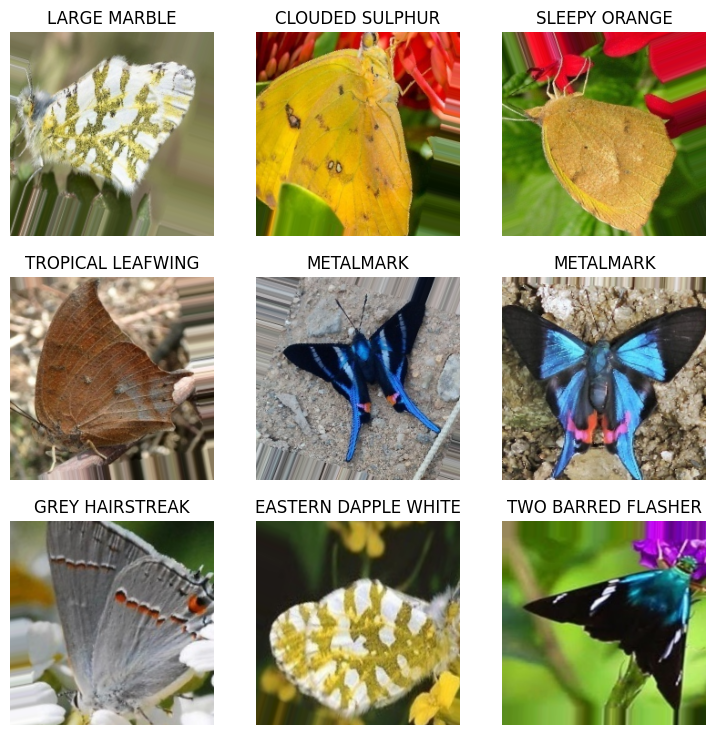

In [11]:
# Funcție pentru afișarea unui batch de imagini și etichete
def show_batch(generator, n=9):
    images, labels = next(generator)  # extragem un batch
    plt.figure(figsize=(9, 9))
    for i in range(n):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        # Afișăm eticheta (clasa) corespunzătoare
        label_index = labels[i].argmax()
        class_name = list(generator.class_indices.keys())[label_index]
        plt.title(class_name)
        plt.axis("off")
    plt.show()

# Apelăm funcția pentru train_generator (care are augmentare)
show_batch(train_generator)

In [145]:
# Metoda 1 - CNN simplu - personalizat
# Obține numărul de clase din generator
num_classes = train_generator.num_classes if hasattr(train_generator, 'num_classes') else len(train_generator.class_indices)

# Definire model CNN
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

# Compilare model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Verificare structură model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 75)             │        19,275 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,265,867 (84.94 MB)

 Trainable params: 22,264,907 (84.93 MB)

 Non-trainable params: 960 (3.75 KB)

In [146]:
# Antrenare Model CNN simplu
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 414ms/step - accuracy: 0.0958 - loss: 4.3576 - val_accuracy: 0.0477 - val_loss: 6.0782
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 396ms/step - accuracy: 0.2736 - loss: 2.8315 - val_accuracy: 0.1031 - val_loss: 3.8341
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 391ms/step - accuracy: 0.3496 - loss: 2.4480 - val_accuracy: 0.2585 - val_loss: 2.9258
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.4371 - loss: 2.0537 - val_accuracy: 0.5262 - val_loss: 1.8226
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.4890 - loss: 1.8299 - val_accuracy: 0.5277 - val_loss: 1.6430
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.5407 - loss: 1.6374 - val_accuracy: 0.5723 - val_loss: 1.5630
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.5768 - loss: 1.5045 - val_accuracy: 0.5815 - val_loss: 1.4850
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.5962 - loss: 1

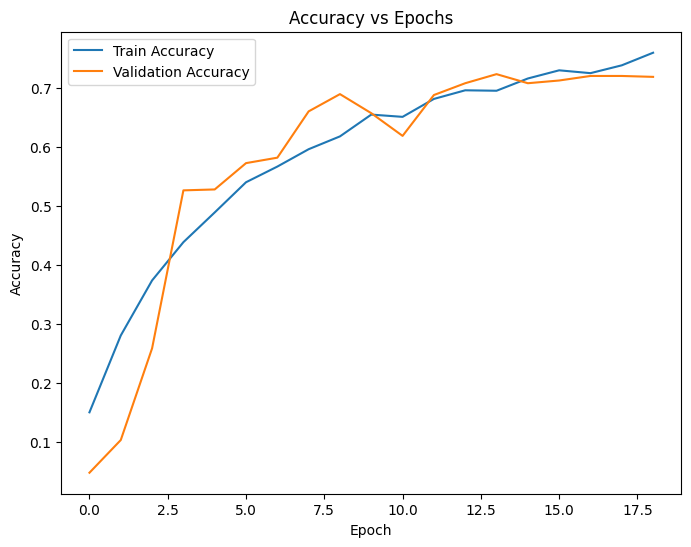

In [147]:
# Plot acuratețe
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

In [148]:
# Evaluare pe test
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7143 - loss: 0.9947
Test accuracy: 0.7292


In [149]:
# Predicții pe test
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step


In [150]:
# Matrice de confuzie
cm = confusion_matrix(y_true, y_pred)
print("Matrice de confuzie:")
print(cm)

Matrice de confuzie:
[[9 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 5]]


In [151]:
# Raport de clasificare
print("Raport clasificare:")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

Raport clasificare:
                           precision    recall  f1-score   support

                   ADONIS       0.90      1.00      0.95         9
AFRICAN GIANT SWALLOWTAIL       1.00      0.88      0.93         8
           AMERICAN SNOOT       1.00      0.38      0.55         8
                    AN 88       1.00      0.89      0.94         9
                  APPOLLO       1.00      0.67      0.80         9
                    ATALA       1.00      1.00      1.00        10
 BANDED ORANGE HELICONIAN       1.00      0.70      0.82        10
           BANDED PEACOCK       0.88      0.88      0.88         8
            BECKERS WHITE       0.60      0.38      0.46         8
         BLACK HAIRSTREAK       0.71      0.62      0.67         8
              BLUE MORPHO       0.60      0.38      0.46         8
        BLUE SPOTTED CROW       0.75      0.75      0.75         8
           BROWN SIPROETA       0.70      0.70      0.70        10
            CABBAGE WHITE       0.78     

In [152]:
# Model 2 - CNN + Machine Learning (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# --- Definim un CNN simplu pentru extragerea caracteristicilor ---
from tensorflow.keras import models, layers

feature_extractor = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
])

feature_extractor.compile(optimizer='adam', loss='categorical_crossentropy')

# --- Extragere caracteristici pentru setul de antrenare ---
def extract_features(generator, feature_model):
    features = []
    labels = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat_batch = feature_model.predict(x_batch)
        features.append(feat_batch)
        labels.append(y_batch)
    features = np.vstack(features)
    labels = np.vstack(labels)
    return features, labels

X_train, y_train = extract_features(train_generator, feature_extractor)
X_val, y_val = extract_features(val_generator, feature_extractor)
X_test, y_test = extract_features(test_generator, feature_extractor)

# Convertim one-hot la etichete simple
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [153]:
# --- Antrenăm Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train_labels)

RandomForestClassifier(random_state=42)

In [154]:
# --- Evaluare pe test ---
y_pred = rf_clf.predict(X_test)

print("Accuracy RF test:", accuracy_score(y_test_labels, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred))
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

Accuracy RF test: 0.3123076923076923
Confusion Matrix:
[[8 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.89      0.67         9
           1       0.25      0.62      0.36         8
           2       0.14      0.12      0.13         8
           3       0.55      0.67      0.60         9
           4       0.07      0.11      0.08         9
           5       0.25      0.60      0.35        10
           6       0.21      0.30      0.25        10
           7       0.80      0.50      0.62         8
           8       0.20      0.12      0.15         8
           9       0.13      0.38      0.19         8
          10       0.00      0.00      0.00         8
          11       0.40      0.25      0.31         8
          12       0.25      0.20      0.22        10
          13       0.39      0.78      0.52  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [155]:
# Model 3 - CNN pre-antrenat MobileNetV2 + Fine-tuning
# Încarcă MobileNetV2 fără stratul de clasificare final, cu greutăți pre-antrenate ImageNet
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Blocăm baza pentru a nu antrena toate straturile de la început
base_model.trainable = False

# Adăugăm straturi Dense pentru clasificare specifică problemelor noastre
inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [158]:
# Antrenare
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.7201 - loss: 1.1820 - val_accuracy: 0.8062 - val_loss: 0.9062
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 392ms/step - accuracy: 0.8012 - loss: 0.8196 - val_accuracy: 0.8246 - val_loss: 0.7521
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.8383 - loss: 0.6516 - val_accuracy: 0.8277 - val_loss: 0.6781
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 390ms/step - accuracy: 0.8695 - loss: 0.5398 - val_accuracy: 0.8508 - val_loss: 0.6139
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.8790 - loss: 0.4700 - val_accuracy: 0.8508 - val_loss: 0.5728
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.8961 - loss: 0.4069 - val_accuracy: 0.8569 - val_loss: 0.5559
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 394ms/step - accuracy: 0.9038 - loss: 0.3586 - val_accuracy: 0.8615 - val_loss: 0.5452
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 396ms/step - accuracy: 0.9098 - loss: 0

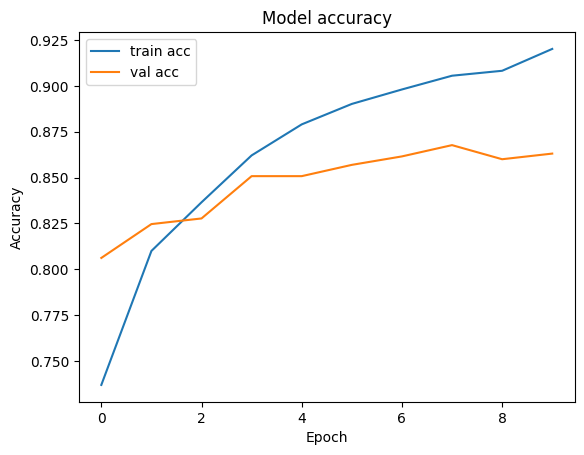

In [159]:
# Plot acuratețe
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [160]:
# Testare
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8778 - loss: 0.4743
Test accuracy: 0.8831


In [161]:
# Predictii pe test
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step


In [162]:
# Obține adevăratele etichete
y_true = test_generator.classes

In [163]:
# Matrice confuzie
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[9 0 0 ... 0 0 0]
 [0 8 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 1 7]]


In [164]:
# Raport clasificare
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         9
           4       0.88      0.78      0.82         9
           5       1.00      1.00      1.00        10
           6       1.00      0.80      0.89        10
           7       1.00      1.00      1.00         8
           8       0.88      0.88      0.88         8
           9       0.89      1.00      0.94         8
          10       1.00      0.88      0.93         8
          11       0.88      0.88      0.88         8
          12       1.00      0.80      0.89        10
          13       0.90      1.00      0.95         9
          14       1.00      0.89      0.94         9
          15       0.90      1.00      0.95         9
          16       1.00      1.00      1.00         8
    

                            Model  Acuratețe Test (%)
0                      CNN Simplu                  73
1                   Random Forest                  31
2  CNN Pre-antrenat (MobileNetV2)                  88


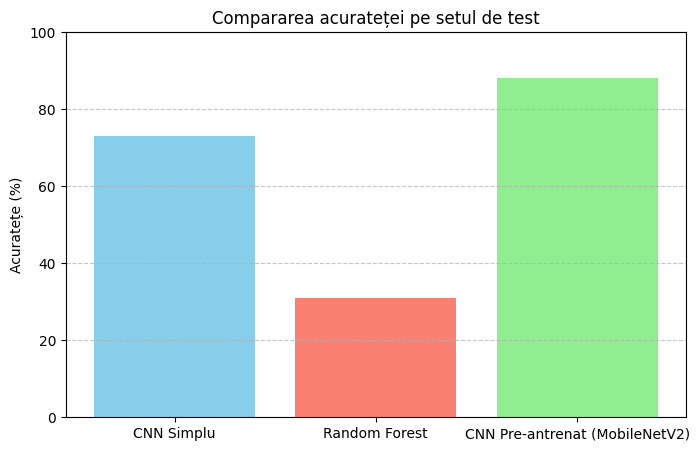

In [167]:
# Comparare rezultate la testare
# Datele cu acuratețea obținută pe setul de test
results = {
    "Model": ["CNN Simplu", "Random Forest", "CNN Pre-antrenat (MobileNetV2)"],
    "Acuratețe Test (%)": [73, 31, 88]
}

# Creăm DataFrame-ul
results_df = pd.DataFrame(results)

# Afișăm tabelul
print(results_df)

# Creăm plot-ul cu bare
plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["Acuratețe Test (%)"], color=["skyblue", "salmon", "lightgreen"])
plt.ylim(0, 100)
plt.title("Compararea acurateței pe setul de test")
plt.ylabel("Acuratețe (%)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()